# Tutorial 2: Scattering from a rigid sphere using a direct formulation

## The problem

In this tutorial, we will solve the same problem as in the [first tutorial](1_sphere_scatterer_null_field.ipynb) amd the using an alternative approach. The formulation used in this tutorial is often called the direct formulation.

### Representation formula

It can be shown that the (unknown) scattered field in our problem can be represented as

$$
p_\text{s} = \int_\Gamma \frac{\partial G(\mathbf x, \mathbf y)}{\partial \mathbf{n}(\mathbf y)}u(\mathbf y)\,\mathrm{d}\mathbf{y} -\int_\Gamma G(\mathbf x, \mathbf y)\lambda(\mathbf y)\,\mathrm{d}\mathbf{y},
$$

where $u$ is the value (or trace) of $p_s$ on $\Gamma$; $\lambda$ is the normal derivative of $p_\text{s}$ on $\Gamma$; and $G(\mathbf x, \mathbf y)$ is the acoustic Green's function given by

$$
G(\mathbf x, \mathbf y):=\frac{\mathrm{e}^{\mathrm{i} k |\mathbf{x}-\mathbf{y}|}}{4 \pi |\mathbf{x}-\mathbf{y}|}.
$$

As we are solving a Neumann problem, $\lambda$ is given by the boundary conditions. In order for the normal derivative of the total field to be 0 on $\Gamma$, we see that

$$\lambda = \frac{\partial p_\text{s}}{\partial\mathbf{n}} = -\frac{\partial p_\text{inc}}{\partial\mathbf{n}} = -\mathrm{i}kn_0\mathrm{e}^{\mathrm{i}kx_0},$$

where $n_0$ is the component of $\mathbf{n}$ in the direction of $x_0$.

Using the single layer ($\mathcal{S}$) and double layer ($\mathcal{D}$) potential operators, the first equation can be rewritten as

$$
p_\text{s} = \mathcal{D}u -\mathcal{S}\lambda.
$$

### Boundary integral equation

Taking the trace of the representation formula, we can derive a boundary integral equation. Using the single layer ($\mathsf{S}$), double layer ($\mathsf{D}$) and identity ($\mathsf{Id}$) boundary operators, this can be written as

$$
(\mathsf{D} - \tfrac{1}{2}\mathsf{Id})u  = \mathsf{S}\lambda.
$$

We will solve a discretisation of the equation to find (an approximation of) $p_s$ on the surface $\Gamma$. This can then be used with the representation formula to evaluate $p_\text{s}$ at various points outside the sphere.

### Solving with Bempp

The following code has been adapted from the [null field example](1_sphere_scatterer_null_field.ipynb). It solves the boundary integral equation

$$
(\mathsf{D} - \tfrac{1}{2}\mathsf{Id})u = \mathsf{S}\lambda,
$$

then uses the solution to compute the values at various points using the representation formula

$$
p_\text{s} = \mathcal{D}u -\mathcal{S}\lambda.
$$

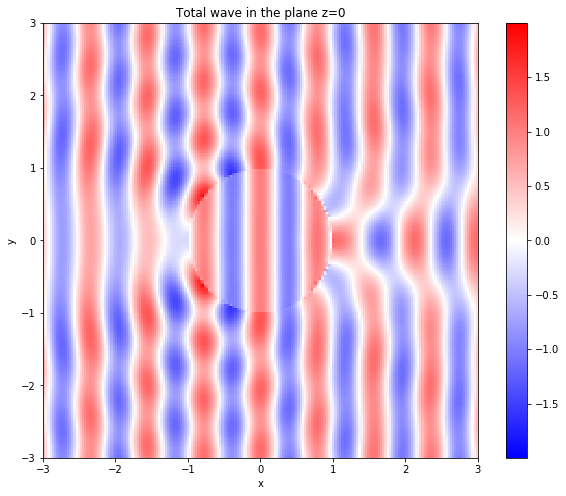

In [1]:
%matplotlib inline

import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

k = 8.

grid = bempp.api.shapes.regular_sphere(3)

space = bempp.api.function_space(grid, "DP", 0)

identity = sparse.identity(space, space, space)
double_layer = helmholtz.double_layer(space, space, space, k)
single_layer = helmholtz.single_layer(space, space, space, k)


@bempp.api.complex_callable
def lambda_callable(x, n, domain_index, result):
    result[0] = -1j * k * np.exp(1j * k * x[0]) * n[0]


lambda_fun = bempp.api.GridFunction(space, fun=lambda_callable)

u, info = gmres(double_layer - 0.5 * identity, single_layer * lambda_fun, tol=1E-5)

Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

single_pot = helmholtz_potential.single_layer(space, points, k)
double_pot = helmholtz_potential.double_layer(space, points, k)

p_total = np.real(np.exp(1j * k * points[0, :])
                  + double_pot.evaluate(u)
                  - single_pot.evaluate(lambda_fun))
p_total = p_total.reshape((Nx, Ny))
vmax = max(np.real(p_total.flat))


fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(p_total.T), extent=[-3, 3, -3, 3], cmap=plt.get_cmap("bwr"), vmin=-vmax, vmax=vmax)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")
plt.show()

Unlike the solution found in the [first tutorial](1_sphere_scatterer_null_field.ipynb), the solution inside the sphere is not 0 in this plot. Using some (slightly ugly) functionality of Numpy, we can hide the solution inside the sphere.

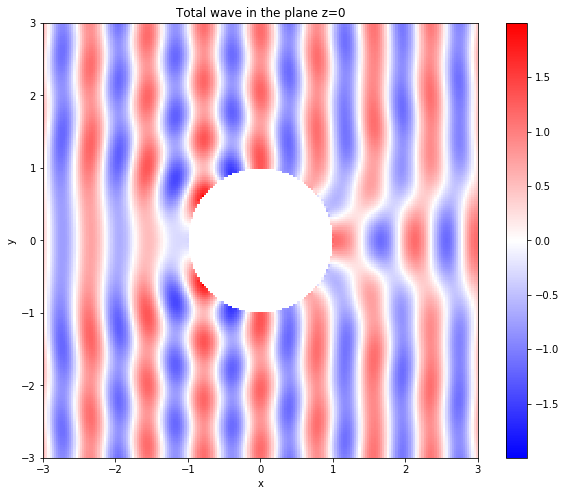

In [2]:
%matplotlib inline

x, y, z = points
idx = np.sqrt(x**2 + y**2) > 1.0

single_pot = helmholtz_potential.single_layer(space, points[:, idx], k)
double_pot = helmholtz_potential.double_layer(space, points[:, idx], k)

u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan
u_evaluated[idx] = np.real(np.exp(1j * k * points[0, idx])
                           + double_pot.evaluate(u)
                           - single_pot.evaluate(lambda_fun)).flat
u_evaluated = u_evaluated.reshape((Nx, Ny))

vmax = max(np.real(u_evaluated.flat))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_evaluated.T), extent=[-3, 3, -3, 3], cmap=plt.get_cmap("bwr"), vmin=-vmax, vmax=vmax)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")
plt.show()

## What next?

After reading this tutorial, you should attempt [exercise 2](../exercises/2_sphere_scatterer.ipynb).